In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import genetools
from covid_serology import config, helpers
from numpy.testing import assert_array_equal

# Load data

In [2]:
mongolia_df = pd.read_csv(f"{config.paths.data_dir}/mongolia_mastersheet.csv")
mongolia_df

,sample_id,Epsilon_ECL,Epsilon_AU,Beta_ECL,Beta_AU,Iota_ECL,Iota_AU,Gamma_ECL,Gamma_AU,B.1.526.2_ECL,...,Kappa_AU,Delta_ECL,Delta_AU,Wuhan_ECL,Wuhan_AU,first_dose_vaccine,second_dose_vaccine,collection_after_vacc,tested_pos,Nucleocapsid
0,mong0145,396565,111205.550800,120139,40086.277990,225975,67886.706540,221054,66529.706190,352769,...,102624.660600,400261,85118.030980,351511,103659.363000,Pfizer,Pfizer,33,NaN,6987.672030
1,mong0149,174289,48586.061240,51303,15467.775110,88942,26293.451400,90552,24680.077400,179395,...,40715.905530,161367,33966.852980,187733,54582.335450,Sinopharm,Sinopharm,63,Yes,340663.488600
2,mong0153,17400,4757.671232,6814,1861.439954,11008,3120.165112,10295,2585.677411,15513,...,4194.067210,17377,3558.357435,16872,4633.291054,Sputnik V,Sputnik V,75,NaN,244.343501
3,mong0156,664,154.614152,524,104.722491,600,126.067394,653,135.447491,1469,...,159.036469,692,124.848563,1529,384.041524,Sinopharm,Sinopharm,70,NaN,8234.466443
4,mong0159,8065,2182.605362,2280,591.605030,3946,1082.080788,4101,1002.029945,7159,...,1859.726803,9258,1875.445044,7429,1992.257119,Sinopharm,Sinopharm,38,NaN,4530.101606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,mong1092,9228,2646.024305,1791,519.417716,5662,1743.726930,2841,773.645610,11804,...,2121.401033,9648,2142.372929,13111,3681.193645,Sputnik V,Sputnik V,99,NaN,2393.413767
193,mong1093,7900,2105.954771,3297,808.914138,5361,1354.040133,4985,1207.240347,9851,...,1712.941479,7809,1619.954392,10140,2733.422491,Sputnik V,Sputnik V,74,NaN,277.122183
194,mong1205,32138,9141.898422,10373,3370.884156,20057,6378.522349,17090,5055.870724,28772,...,8309.990587,31665,6958.362747,32636,9228.140021,Sputnik V,Sputnik V,94,NaN,626.829708
195,mong1206,2492,707.190387,920,247.029286,1501,431.917264,1435,370.840412,2472,...,626.721545,2502,551.889230,2691,733.383507,Sputnik V,Sputnik V,107,NaN,251.736425


In [3]:
# Exclude vaccinees who also tested positive
# TODO: keep as a separate group

# use nucleocapsid cutoff, for all but sinopharm (which has killed virus)
nucleocapsid_cutoff_for_previous_infection = 3743.2
mongolia_df_without_sinopharm = mongolia_df[
    ~(
        (mongolia_df["first_dose_vaccine"] == "Sinopharm")
        | (mongolia_df["second_dose_vaccine"] == "Sinopharm")
    )
]
assert mongolia_df_without_sinopharm.shape[0] < mongolia_df.shape[0]
mongolia_df["evidence_of_previous_infection"] = (
    mongolia_df_without_sinopharm["Nucleocapsid"] > 3743.2
)
mongolia_df["evidence_of_previous_infection"]

0       True
1        NaN
2      False
3        NaN
4        NaN
       ...  
192    False
193    False
194    False
195    False
196    False
Name: evidence_of_previous_infection, Length: 197, dtype: object

In [4]:
mongolia_df["evidence_of_previous_infection"].value_counts(), mongolia_df[
    "evidence_of_previous_infection"
].isna().sum()

(False    125
 True      17
 Name: evidence_of_previous_infection, dtype: int64,
 55)

In [5]:
# for sinopharm, fillna with whether clinical record of positive test date exists
mongolia_df["evidence_of_previous_infection"] = mongolia_df[
    "evidence_of_previous_infection"
].fillna(~mongolia_df["tested_pos"].isna())

# all should now have a yes or no answer for whether previously infected
assert not mongolia_df["evidence_of_previous_infection"].isna().any()

mongolia_df["evidence_of_previous_infection"]

0       True
1       True
2      False
3      False
4      False
       ...  
192    False
193    False
194    False
195    False
196    False
Name: evidence_of_previous_infection, Length: 197, dtype: bool

In [6]:
mongolia_df["evidence_of_previous_infection"].value_counts()

False    177
True      20
Name: evidence_of_previous_infection, dtype: int64

In [7]:
# Exclude vaccinees who also tested positive
# TODO: keep as a separate group
mongolia_df = mongolia_df[~mongolia_df["evidence_of_previous_infection"]]
mongolia_df

,sample_id,Epsilon_ECL,Epsilon_AU,Beta_ECL,Beta_AU,Iota_ECL,Iota_AU,Gamma_ECL,Gamma_AU,B.1.526.2_ECL,...,Delta_ECL,Delta_AU,Wuhan_ECL,Wuhan_AU,first_dose_vaccine,second_dose_vaccine,collection_after_vacc,tested_pos,Nucleocapsid,evidence_of_previous_infection
2,mong0153,17400,4757.671232,6814,1861.439954,11008,3120.165112,10295,2585.677411,15513,...,17377,3558.357435,16872,4633.291054,Sputnik V,Sputnik V,75,NaN,244.343501,False
3,mong0156,664,154.614152,524,104.722491,600,126.067394,653,135.447491,1469,...,692,124.848563,1529,384.041524,Sinopharm,Sinopharm,70,NaN,8234.466443,False
4,mong0159,8065,2182.605362,2280,591.605030,3946,1082.080788,4101,1002.029945,7159,...,9258,1875.445044,7429,1992.257119,Sinopharm,Sinopharm,38,NaN,4530.101606,False
7,mong0184,1096,274.435069,491,105.143169,735,174.108990,663,138.972078,1047,...,1238,230.891334,1060,255.441751,Sinopharm,Sinopharm,65,NaN,161.537591,False
8,mong0185,1126,282.577302,548,120.340822,754,179.382573,848,184.790715,1035,...,1127,208.459406,1075,259.416168,Sinopharm,Sinopharm,63,NaN,832.062364,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,mong1092,9228,2646.024305,1791,519.417716,5662,1743.726930,2841,773.645610,11804,...,9648,2142.372929,13111,3681.193645,Sputnik V,Sputnik V,99,NaN,2393.413767,False
193,mong1093,7900,2105.954771,3297,808.914138,5361,1354.040133,4985,1207.240347,9851,...,7809,1619.954392,10140,2733.422491,Sputnik V,Sputnik V,74,NaN,277.122183,False
194,mong1205,32138,9141.898422,10373,3370.884156,20057,6378.522349,17090,5055.870724,28772,...,31665,6958.362747,32636,9228.140021,Sputnik V,Sputnik V,94,NaN,626.829708,False
195,mong1206,2492,707.190387,920,247.029286,1501,431.917264,1435,370.840412,2472,...,2502,551.889230,2691,733.383507,Sputnik V,Sputnik V,107,NaN,251.736425,False


In [8]:
mongolia_df.columns

Index(['sample_id', 'Epsilon_ECL', 'Epsilon_AU', 'Beta_ECL', 'Beta_AU',
       'Iota_ECL', 'Iota_AU', 'Gamma_ECL', 'Gamma_AU', 'B.1.526.2_ECL',
       'B.1.526.2_AU', 'Alpha_ECL', 'Alpha_AU', 'P.3_ECL', 'P.3_AU',
       'Kappa_ECL', 'Kappa_AU', 'Delta_ECL', 'Delta_AU', 'Wuhan_ECL',
       'Wuhan_AU', 'first_dose_vaccine', 'second_dose_vaccine',
       'collection_after_vacc', 'tested_pos', 'Nucleocapsid',
       'evidence_of_previous_infection'],
      dtype='object')

In [9]:
measurement_cols = mongolia_df.columns[mongolia_df.columns.str.contains("AU")]
helpers.confirm_all_measurement_columns_are_present(measurement_cols)
measurement_cols

Index(['Epsilon_AU', 'Beta_AU', 'Iota_AU', 'Gamma_AU', 'B.1.526.2_AU',
       'Alpha_AU', 'P.3_AU', 'Kappa_AU', 'Delta_AU', 'Wuhan_AU'],
      dtype='object')

<AxesSubplot:>

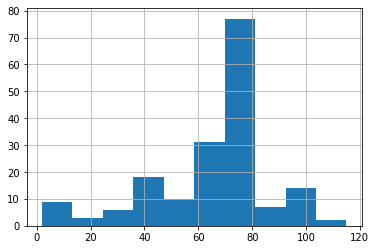

In [10]:
mongolia_df["collection_after_vacc"].hist()

In [11]:
# no need to take means, already taken
assert all(mongolia_df.groupby(["sample_id", "collection_after_vacc"]).size()) == 1

In [12]:
# only one sample per patient
assert all(mongolia_df["sample_id"].value_counts() == 1)

# reformat

In [13]:
mongolia_df_obs = mongolia_df[
    [
        "sample_id",
        "collection_after_vacc",
        "first_dose_vaccine",
        "second_dose_vaccine",
    ]
].copy()

mongolia_df_obs.rename(columns={"collection_after_vacc": "Timepoint"}, inplace=True)

mongolia_df_obs["Status"] = (
    mongolia_df_obs["first_dose_vaccine"] + "-" + mongolia_df_obs["second_dose_vaccine"]
)

# capitalize columns for consistency - only the first letter
# and set index
mongolia_df_obs = mongolia_df_obs.rename(
    columns=lambda s: s[0].upper() + s[1:]
).set_index("Sample_id")

# anndata wants string index
mongolia_df_obs.index = mongolia_df_obs.index.astype(str)

mongolia_df_obs

,Timepoint,First_dose_vaccine,Second_dose_vaccine,Status
Sample_id,,,,
mong0153,75,Sputnik V,Sputnik V,Sputnik V-Sputnik V
mong0156,70,Sinopharm,Sinopharm,Sinopharm-Sinopharm
mong0159,38,Sinopharm,Sinopharm,Sinopharm-Sinopharm
mong0184,65,Sinopharm,Sinopharm,Sinopharm-Sinopharm
mong0185,63,Sinopharm,Sinopharm,Sinopharm-Sinopharm
...,...,...,...,...
mong1092,99,Sputnik V,Sputnik V,Sputnik V-Sputnik V
mong1093,74,Sputnik V,Sputnik V,Sputnik V-Sputnik V
mong1205,94,Sputnik V,Sputnik V,Sputnik V-Sputnik V


In [14]:
# extract AU measurement cols, and set index to match obs
mongolia_df_X = (
    mongolia_df[measurement_cols]
    .rename(columns=lambda col: col.replace("_AU", ""))
    .set_index(mongolia_df_obs.index)
)
mongolia_df_X

,Epsilon,Beta,Iota,Gamma,B.1.526.2,Alpha,P.3,Kappa,Delta,Wuhan
Sample_id,,,,,,,,,,
mong0153,4757.671232,1861.439954,3120.165112,2585.677411,3776.616481,2938.934956,1658.569714,4194.067210,3558.357435,4633.291054
mong0156,154.614152,104.722491,126.067394,135.447491,322.034640,305.687952,130.092636,159.036469,124.848563,384.041524
mong0159,2182.605362,591.605030,1082.080788,1002.029945,1713.322559,1358.068145,614.723109,1859.726803,1875.445044,1992.257119
mong0184,274.435069,105.143169,174.108990,138.972078,227.705221,205.694431,97.188464,268.368257,230.891334,255.441751
mong0185,282.577302,120.340822,179.382573,184.790715,224.842356,214.025723,125.667372,262.826798,208.459406,259.416168
...,...,...,...,...,...,...,...,...,...,...
mong1092,2646.024305,519.417716,1743.726930,773.645610,3001.669909,1750.139123,702.619770,2121.401033,2142.372929,3681.193645
mong1093,2105.954771,808.914138,1354.040133,1207.240347,2293.892267,1951.906687,779.639330,1712.941479,1619.954392,2733.422491
mong1205,9141.898422,3370.884156,6378.522349,5055.870724,7435.147519,5695.520033,3918.249602,8309.990587,6958.362747,9228.140021


In [15]:
adata = anndata.AnnData(X=mongolia_df_X, obs=mongolia_df_obs)
adata

AnnData object with n_obs × n_vars = 177 × 10
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status'

In [16]:
adata.obs

,Timepoint,First_dose_vaccine,Second_dose_vaccine,Status
Sample_id,,,,
mong0153,75,Sputnik V,Sputnik V,Sputnik V-Sputnik V
mong0156,70,Sinopharm,Sinopharm,Sinopharm-Sinopharm
mong0159,38,Sinopharm,Sinopharm,Sinopharm-Sinopharm
mong0184,65,Sinopharm,Sinopharm,Sinopharm-Sinopharm
mong0185,63,Sinopharm,Sinopharm,Sinopharm-Sinopharm
...,...,...,...,...
mong1092,99,Sputnik V,Sputnik V,Sputnik V-Sputnik V
mong1093,74,Sputnik V,Sputnik V,Sputnik V-Sputnik V
mong1205,94,Sputnik V,Sputnik V,Sputnik V-Sputnik V


In [17]:
adata.var

""
Epsilon
Beta
Iota
Gamma
B.1.526.2
Alpha
P.3
Kappa
Delta
Wuhan


In [18]:
adata.var["virus"] = adata.var_names
adata.var["target"] = "RBD"
adata.var["variant_plate_type"] = "Variant"
adata.var["antibody"] = "IgG"
adata.var

,virus,target,variant_plate_type,antibody
Epsilon,Epsilon,RBD,Variant,IgG
Beta,Beta,RBD,Variant,IgG
Iota,Iota,RBD,Variant,IgG
Gamma,Gamma,RBD,Variant,IgG
B.1.526.2,B.1.526.2,RBD,Variant,IgG
Alpha,Alpha,RBD,Variant,IgG
P.3,P.3,RBD,Variant,IgG
Kappa,Kappa,RBD,Variant,IgG
Delta,Delta,RBD,Variant,IgG
Wuhan,Wuhan,RBD,Variant,IgG


In [19]:
adata.X

array([[ 4757.6714  ,  1861.44    ,  3120.165   , ...,  4194.0674  ,
         3558.3574  ,  4633.291   ],
       [  154.61415 ,   104.72249 ,   126.06739 , ...,   159.03647 ,
          124.848564,   384.04153 ],
       [ 2182.6055  ,   591.60504 ,  1082.0808  , ...,  1859.7268  ,
         1875.4451  ,  1992.2571  ],
       ...,
       [ 9141.898   ,  3370.8843  ,  6378.5225  , ...,  8309.99    ,
         6958.363   ,  9228.14    ],
       [  707.19037 ,   247.02928 ,   431.91727 , ...,   626.72156 ,
          551.8892  ,   733.3835  ],
       [49298.93    , 16804.086   , 33007.926   , ..., 46707.926   ,
        37414.35    , 67121.87    ]], dtype=float32)

In [20]:
adata

AnnData object with n_obs × n_vars = 177 × 10
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status'
    var: 'virus', 'target', 'variant_plate_type', 'antibody'

<AxesSubplot:>

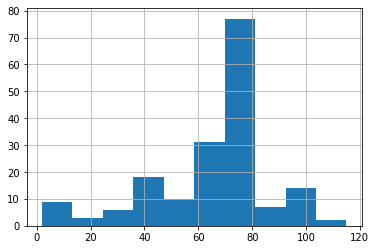

In [21]:
adata.obs["Timepoint"].hist()

In [22]:
adata = adata[(adata.obs["Timepoint"] >= 60) & (adata.obs["Timepoint"] < 120)].copy()
adata

AnnData object with n_obs × n_vars = 131 × 10
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status'
    var: 'virus', 'target', 'variant_plate_type', 'antibody'

In [23]:
adata.var["timepoint"] = "week 7 and later / 3 months"
adata.var

,virus,target,variant_plate_type,antibody,timepoint
Epsilon,Epsilon,RBD,Variant,IgG,week 7 and later / 3 months
Beta,Beta,RBD,Variant,IgG,week 7 and later / 3 months
Iota,Iota,RBD,Variant,IgG,week 7 and later / 3 months
Gamma,Gamma,RBD,Variant,IgG,week 7 and later / 3 months
B.1.526.2,B.1.526.2,RBD,Variant,IgG,week 7 and later / 3 months
Alpha,Alpha,RBD,Variant,IgG,week 7 and later / 3 months
P.3,P.3,RBD,Variant,IgG,week 7 and later / 3 months
Kappa,Kappa,RBD,Variant,IgG,week 7 and later / 3 months
Delta,Delta,RBD,Variant,IgG,week 7 and later / 3 months
Wuhan,Wuhan,RBD,Variant,IgG,week 7 and later / 3 months


In [24]:
# create combined name
adata.var["combined_name"] = adata.var.apply("_".join, axis=1)
adata.var = adata.var.set_index("combined_name")

In [25]:
adata.var

,virus,target,variant_plate_type,antibody,timepoint
combined_name,,,,,
Epsilon_RBD_Variant_IgG_week 7 and later / 3 months,Epsilon,RBD,Variant,IgG,week 7 and later / 3 months
Beta_RBD_Variant_IgG_week 7 and later / 3 months,Beta,RBD,Variant,IgG,week 7 and later / 3 months
Iota_RBD_Variant_IgG_week 7 and later / 3 months,Iota,RBD,Variant,IgG,week 7 and later / 3 months
Gamma_RBD_Variant_IgG_week 7 and later / 3 months,Gamma,RBD,Variant,IgG,week 7 and later / 3 months
B.1.526.2_RBD_Variant_IgG_week 7 and later / 3 months,B.1.526.2,RBD,Variant,IgG,week 7 and later / 3 months
Alpha_RBD_Variant_IgG_week 7 and later / 3 months,Alpha,RBD,Variant,IgG,week 7 and later / 3 months
P.3_RBD_Variant_IgG_week 7 and later / 3 months,P.3,RBD,Variant,IgG,week 7 and later / 3 months
Kappa_RBD_Variant_IgG_week 7 and later / 3 months,Kappa,RBD,Variant,IgG,week 7 and later / 3 months
Delta_RBD_Variant_IgG_week 7 and later / 3 months,Delta,RBD,Variant,IgG,week 7 and later / 3 months


In [26]:
adata.obs["Status"].value_counts()

AZ-AZ                  37
Sinopharm-Sinopharm    36
Sputnik V-Sputnik V    33
Pfizer-Pfizer          25
Name: Status, dtype: int64

In [27]:
adata.write(f"{config.paths.generated_data_dir}/partial.mongolia_vaccines.h5")

... storing 'First_dose_vaccine' as categorical


... storing 'Second_dose_vaccine' as categorical


... storing 'Status' as categorical


... storing 'target' as categorical


... storing 'variant_plate_type' as categorical


... storing 'antibody' as categorical


... storing 'timepoint' as categorical
